In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(42)

In [2]:
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 75000
n_iter = 1000
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [3]:
def load_all(fname):
    return joblib.load(fname)

X_train_all = load_all(path+"X_train_all.jblib")
X_val_all = load_all(path+"X_val_all.jblib")

In [4]:
print(len(X_train_all))

75000


In [5]:
def load_y(fname):
    return np.array(pickle.load(open(fname,"rb")))

y_train = load_y(path+"y_train.p")
y_val = load_y(path+"y_val.p")

In [6]:
from sklearn import svm

In [7]:
# from sklearn.model_selection import GridSearchCV
# parameters = {
#     'penalty': ['l1','l2'],
#     #'dual' : [False, True],
# #     'loss' : ['hinge','squared_hinge'],
#      'C': [0.001, 0.01, 0.1, 1]
#  }

In [8]:
# gs_clf = GridSearchCV(svm.LinearSVC(verbose=4,max_iter=n_iter,dual=False), 
#                       parameters, cv=3, iid=True, n_jobs=1,verbose=4)

In [9]:
# stime = time.time()
# model = gs_clf.fit(X_train_all, y_train)
# print ("Training time:",time.time() - stime)

In [10]:
# model.best_score_

In [20]:
from sklearn.calibration import CalibratedClassifierCV
# ccmodel = CalibratedClassifierCV(model, cv='prefit')
# ccmodel.fit(X_val_all, y_val)

In [12]:
# ccmodel.score(X_val_all, y_val)

In [13]:
# print(model.best_params_)
# for param_name in sorted(parameters.keys()):
#     print("%s: %r" % (param_name, model.best_params_[param_name]))

In [14]:
# pickle.dump(model,open("SVM_All_SVCLinear_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [16]:
X_test_all = load_all(path+"X_test_all.jblib")
y_test = load_y(path+"y_test.p")

In [17]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [18]:
from sklearn.metrics import accuracy_score
import sklearn

In [29]:
valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []


# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel =svm.LinearSVC(verbose=4,
                             max_iter=n_iter,
                             dual=False,
                             C=0.001,
                             penalty='l2')

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    ccBestModel = CalibratedClassifierCV(bestModel, cv=2)
    ccBestModel.fit(X_train_all[:eachTrain],y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    #print (X_train_cls.shape,y_train.shape,X_val_f.shape, y_val.shape)
    
    stime=time.time()
    preds_val = ccBestModel.predict(X_val_all)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)    
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test = ccBestModel.predict(X_test_all)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = ccBestModel.predict_proba(X_test_all)
    #print (bestModel.decision_function(X_test_f))
    #input("WWW")
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)
print (precisionAt1)
print (precisionAt3)
print (preds_test_probs)

SampleSize: 100
[LibLinear][LibLinear]Train Time:4.05 sec
Validation Accuracy: 54.71%
Validation Time:0.76 sec
Test Accuracy: 55.69%
Test Time:0.73 sec
(0.486000000000002, 0.24666666666666667, 0.6186666666666667)
MRR: 0.486000000000002
MRR Time:1.58 sec
SampleSize: 500
[LibLinear][LibLinear]Train Time:48.14 sec
Validation Accuracy: 56.49%
Validation Time:0.93 sec
Test Accuracy: 56.09%
Test Time:0.80 sec
(0.48441111111111257, 0.24, 0.6206666666666667)
MRR: 0.48441111111111257
MRR Time:1.26 sec
SampleSize: 1000
[LibLinear][LibLinear]Train Time:158.63 sec
Validation Accuracy: 55.75%
Validation Time:0.89 sec
Test Accuracy: 57.02%
Test Time:0.90 sec
(0.49364444444444583, 0.25466666666666665, 0.6373333333333333)
MRR: 0.49364444444444583
MRR Time:1.48 sec
SampleSize: 10000
[LibLinear]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Train Time:1836.59 sec
Validation Accuracy: 61.51%
Validation Time:0.87 sec
Test Accuracy: 61.72%
Test Time:0.96 sec
(0.5445925925925948, 0.306, 0.7213333333333334)
MRR: 0.5445925925925948
MRR Time:1.74 sec
SampleSize: 20000
[LibLinear]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Train Time:3575.56 sec
Validation Accuracy: 62.43%
Validation Time:0.90 sec
Test Accuracy: 62.51%
Test Time:0.85 sec
(0.5505126984127005, 0.31666666666666665, 0.7186666666666667)
MRR: 0.5505126984127005
MRR Time:1.21 sec
SampleSize: 50000
[LibLinear]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Train Time:10820.37 sec
Validation Accuracy: 62.95%
Validation Time:0.89 sec
Test Accuracy: 63.01%
Test Time:0.91 sec
(0.5672666666666696, 0.3393333333333333, 0.74)
MRR: 0.5672666666666696
MRR Time:1.61 sec
SampleSize: 75000
[LibLinear]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Train Time:18290.19 sec
Validation Accuracy: 63.63%
Validation Time:0.83 sec
Test Accuracy: 62.59%
Test Time:0.86 sec
(0.5534111111111139, 0.31666666666666665, 0.7406666666666667)
MRR: 0.5534111111111139
MRR Time:1.73 sec
[0.5471, 0.5649, 0.5575, 0.6151, 0.6243, 0.6295, 0.6363]
[0.5569, 0.5609, 0.5702, 0.6172, 0.6251, 0.6301, 0.6259]
[0.486000000000002, 0.48441111111111257, 0.49364444444444583, 0.5445925925925948, 0.5505126984127005, 0.5672666666666696, 0.5534111111111139]
[0.24666666666666667, 0.24, 0.25466666666666665, 0.306, 0.31666666666666665, 0.3393333333333333, 0.31666666666666665]
[0.6186666666666667, 0.6206666666666667, 0.6373333333333333, 0.7213333333333334, 0.7186666666666667, 0.74, 0.7406666666666667]
[[0.58272009 0.41727991]
 [0.65192916 0.34807084]
 [0.54018997 0.45981003]
 ...
 [0.48231802 0.51768198]
 [0.48231802 0.51768198]
 [0.48231802 0.51768198]]


In [23]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SVM_All_LinearSVC_Accuracy.png")
    #plt.show()

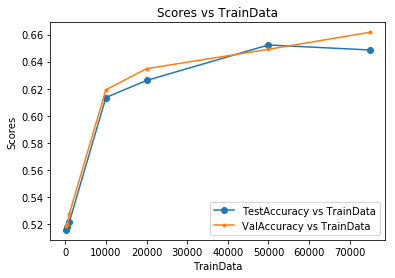

In [24]:
accuracyVisualization()

In [25]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SVM_All_LinearSVC_Mrr.png")
    plt.show()

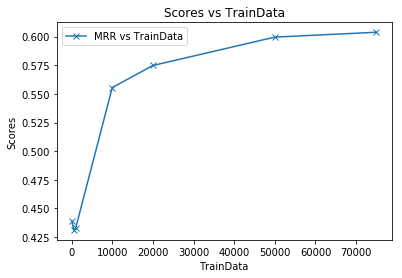

In [26]:
mrrVisualization()

In [27]:
def precisionVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='x')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='o')
    plt.title("Precisions vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Precisions")
    fig.savefig("SVM_All_LinearSVC_Precision.png")
    plt.show()

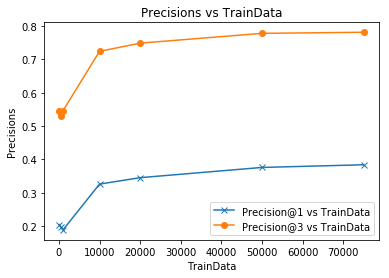

In [28]:
precisionVisualization()